# First method: explicit in time, forward / backword differences in space
## Setting up the problem by defining a function for the derivative

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pickle


# Notice that the length is one! 
dx = 0.001
x_f = 1
n_x = int(x_f/dx) 

# Here are the paramters. Make sure to use the same in all simulations :-) 
G = 1e-5
R = 0.01
L = 3
C = 3
RL = 3.0 # TURNS OUT this needs to be the same as L and C to have a nice solution.

x_array = np.arange(n_x) * dx


def get_derivative(t, x):
    v = x[:n_x]
    i = x[n_x:]

    # low frequency example:
    # SINE
    # u = np.sin(3/2*np.pi*t) 
    # (1-COSINE)/2
    u = (1-np.cos(3/2 * np.pi * t))/2

    # very low frequency example:
    # SINE
    # u = np.sin(1/4.5*3/2*np.pi*t) 
    # (1-COSINE)/2
    # u = (1-np.cos(1/4.5 * 3/2 * np.pi * t))/2
    

    # if t>= 1 and t<= 4:
    #     u=1
    # else:
    #     u=0

    v[0] = u
    i[-1] = v[-1]/RL
    
    der_v = np.zeros(v.shape)
    der_i = np.zeros(i.shape)

    der_i[:-1] = - 1/L* ( (v[1:] - v[:-1] ) / dx + i[:-1] * R )
    
    der_v[1:]  = - 1/C* ( (i[1:] - i[:-1] ) / dx + v[1:]  * G )

    #introduce fault
    if t > 3 and t<4:
        thiccness = 0.02
        thiccness = int(thiccness/dx)
        interval = np.arange(int(n_x/2)-thiccness,int(n_x/2)+thiccness)
        der_v[interval] = 1/C* ((i[interval-1] - i[interval])/dx - v[interval]* G*1e7)
    
    return np.concatenate((der_v, der_i))



sol = solve_ivp(get_derivative, [0, 10], np.zeros(2*n_x), method='RK45', dense_output=True, rtol=1e-9, atol=1e-9) 
    

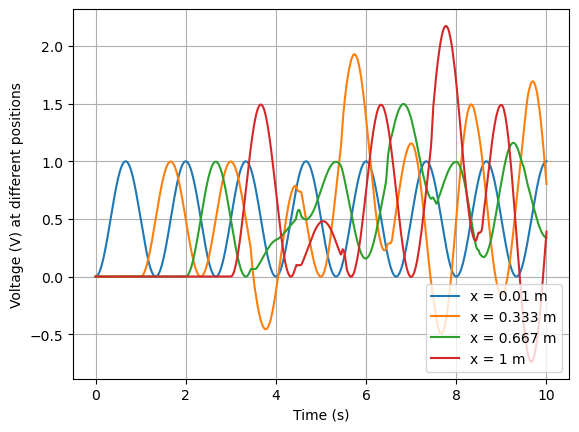

# time steps:  12099


Text(0.5, 0, 'Position (m)')

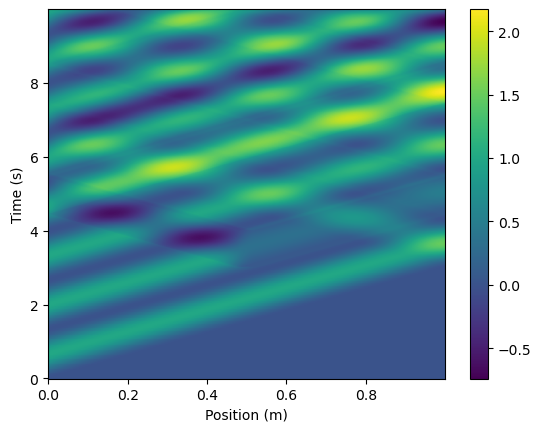

In [60]:
plt.figure()
plt.plot(sol.t, sol.y[0,:], label="x = 0.01 m")
plt.plot(sol.t, sol.y[int(n_x/3),:], label="x = 0.333 m")
plt.plot(sol.t, sol.y[int(2*n_x/3),:], label="x = 0.667 m")
plt.plot(sol.t, sol.y[n_x-1,:], label= "x = 1 m")
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V) at different positions")
plt.legend(loc="lower right")
plt.show()

print('# time steps: ', len(sol.t))

fig = plt.figure()
ax = fig.subplots()
T, X = np.meshgrid(sol.t[0::10], x_array)
here = ax.pcolormesh( X, T, sol.y[:n_x, 0::10])
fig.colorbar(here)
ax.set_ylabel("Time (s)")
ax.set_xlabel("Position (m)")

## Saving the boundary conditions and initial conditions to train the PINN with them!

Plotting the boundary / initial conditions

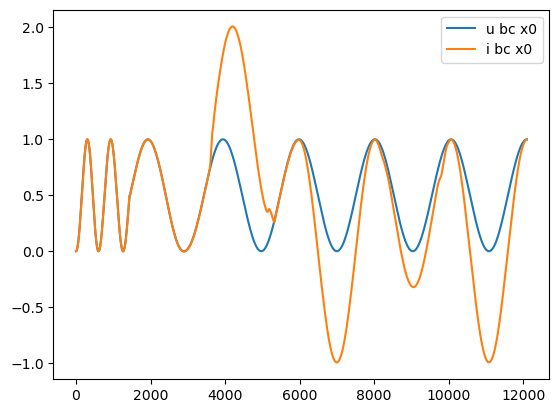

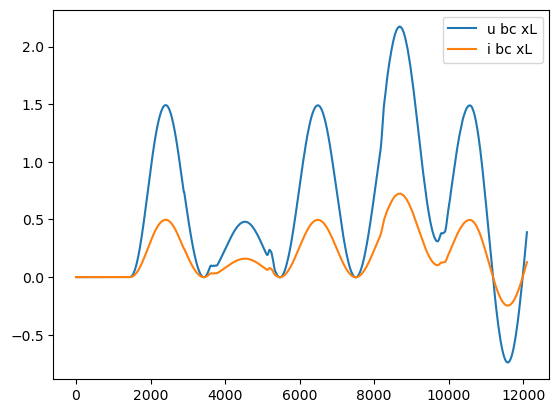

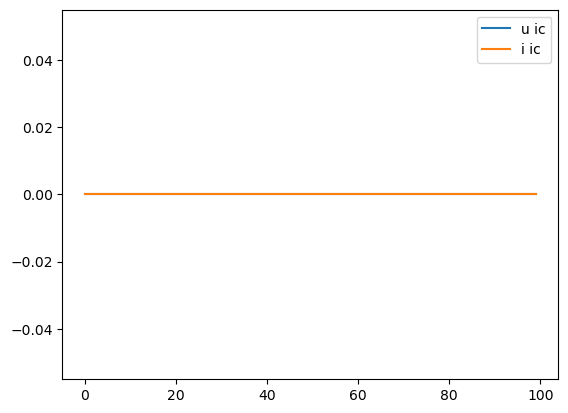

In [61]:
# Create a dictionary to hold all variables
data = {
    'u_bc_x0':sol.y[0,:], #::100 
    'u_bc_xL':sol.y[n_x-1,:], #::100 
    'i_bc_x0':sol.y[n_x,:], #::100 
    'i_bc_xL': sol.y[-1,:], #::100
    'u_ic': sol.y[0:n_x:10,0],
    'i_ic': sol.y[n_x:-1:10,0]
}

u_bc_x0 = data['u_bc_x0']
u_bc_xL = data['u_bc_xL']
i_bc_x0 = data['i_bc_x0']
i_bc_xL = data['i_bc_xL']
u_ic = data['u_ic']
i_ic = data['i_ic']

import matplotlib.pyplot as plt

plt.figure()
plt.plot(u_bc_x0)
plt.plot(i_bc_x0)
plt.legend(['u bc x0','i bc x0'])
plt.show()

plt.figure()
plt.plot(u_bc_xL)
plt.plot(i_bc_xL)
plt.legend(['u bc xL','i bc xL'])
plt.show()

plt.figure()
plt.plot(u_ic)
plt.plot(i_ic)
plt.legend(['u ic','i ic'])
plt.show()

Saving them as pickles

In [62]:
# Save all variables in one file
with open('data/NS_to_PINN/Faults/cos_signal_slow_fault.pkl', 'wb') as f:
    pickle.dump(data, f)

and reading them again

In [31]:
import pickle

with open('data/NS_to_PINN/cos_signal_very_slow.pkl', 'rb') as file:
    data = pickle.load(file)

u_bc_x0 = data['u_bc_x0']
u_bc_xL = data['u_bc_xL']
i_bc_x0 = data['i_bc_x0']
i_bc_xL = data['i_bc_xL']
u_ic = data['u_ic']
i_ic = data['i_ic']

